Load the liabrary

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_classif
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

Load data

In [2]:
df = pd.read_csv("../data/laptop_final.csv")
print(df.head(5))
print(df.columns)

                                                link  \
0  https://laptopmedia.com/laptop-specs/asus-rog-...   
1  https://laptopmedia.com/laptop-specs/asus-rog-...   
2  https://laptopmedia.com/laptop-specs/asus-rog-...   
3  https://laptopmedia.com/laptop-specs/asus-rog-...   
4  https://laptopmedia.com/laptop-specs/asus-rog-...   

                       name  Display Size  Resolution: width  \
0        ASUS ROG Strix G17          17.3             2560.0   
1  ASUS ROG Zephyrus Duo 16          16.0             2560.0   
2  ASUS ROG Zephyrus Duo 16          16.0             2560.0   
3  ASUS ROG Zephyrus Duo 16          16.0             2560.0   
4        ASUS ROG Strix G17          17.3             2560.0   

   Resolution: height  Refresh Rate       Panel Type  Disk Capacity  SSD  HDD  \
0              1440.0         240.0     IPS + G-Sync         2000.0  1.0  0.0   
1              1600.0         240.0   IPS + FreeSync        16000.0  1.0  0.0   
2              1600.0         240.0

In [3]:
# Drop unecessary columns
# Drop Ethernet LAN due to its large missing values 
df=df.drop(columns=["link","name","Total Score","Work Score","Display Score","Play Score","Cost","CPU: Codename","GPU: Name","CPU: Name","Ethernet LAN"])
df = df.drop_duplicates()

Drop nan values

In [4]:
df.isnull().sum()

Display Size                                   0
Resolution: width                              0
Resolution: height                             0
Refresh Rate                                   0
Panel Type                                     0
Disk Capacity                                  0
SSD                                            0
HDD                                            0
SSHD                                           0
Optane                                         0
RAM Capacity                                 256
RAM Type                                   26332
OS                                           659
Body material: plastic / polycarbonate         0
Body material: aluminum                        0
Body material: magnesium alloy                 0
Body material: glass fiber                     0
Body material: carbon                          0
Body material: magnesium-lithium alloy         0
Body material: plastic                         0
Body material: matte

In [5]:
df2 = df.dropna() # drop all nan value due to the large datset 
print("The number of data points before drop nan is: {} and after drop nan values is: {}".format(df.shape[0], df2.shape[0]))

The number of data points before drop nan is: 148426 and after drop nan values is: 77987


Add more features following our knowledge about laptop architecture

In [6]:
# Add the connectivity score that is the sum of connection gate availability in laptop
df2['Connectivity Score'] = df2[['USB Type-C', 'USB Type-A', 'HDMI', 'Card Reader']].sum(axis=1)

# Add the Lightweight Build for specific low-weighted materials.
lightweight_materials = ['Body material: magnesium alloy', 'Body material: carbon', 'Body material: plastic']
threshold_weight = 2.0
df2['Lightweight Build'] = df2.apply(lambda x: 1 if any(mat in x for mat in lightweight_materials) and x['Weight'] < threshold_weight else 0, axis=1)
print(df2['Lightweight Build'].value_counts())

# Add the Portability feature count as sum of the convinience of laptop
df2['Portability Feature Count'] = df2[['Fingerprint reader', 'Backlit keyboard', 'Security Lock slot']].sum(axis=1)


C:\Users\Acer\AppData\Local\Temp\ipykernel_24648\886753244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Connectivity Score'] = df2[['USB Type-C', 'USB Type-A', 'HDMI', 'Card Reader']].sum(axis=1)


Lightweight Build
0    39188
1    38799
Name: count, dtype: int64


C:\Users\Acer\AppData\Local\Temp\ipykernel_24648\886753244.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Lightweight Build'] = df2.apply(lambda x: 1 if any(mat in x for mat in lightweight_materials) and x['Weight'] < threshold_weight else 0, axis=1)
C:\Users\Acer\AppData\Local\Temp\ipykernel_24648\886753244.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Portability Feature Count'] = df2[['Fingerprint reader', 'Backlit keyboard', 'Security Lock slot']].sum(axis=1)


Divide into train test split before encoding to prevent overfiting

In [7]:
target="Portability Score"
X=df2.drop(columns=[target])
y=df2[target]

In [8]:
# train validation split with ratio is 0.2 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=123)
# features for encoding 
cols_to_encode=["Panel Type","RAM Type","OS","GPU: Architecture","GPU: Memory Type"]

Encode categorical columns using target encoding

In [9]:
for col in cols_to_encode:
    print(f"Number of unique values in {col}: ",df2[col].nunique())

Number of unique values in Panel Type:  11
Number of unique values in RAM Type:  5
Number of unique values in OS:  9
Number of unique values in GPU: Architecture:  40
Number of unique values in GPU: Memory Type:  3


In [10]:
# Encode the categorical features 
encoder=TargetEncoder(cols=cols_to_encode)
X_train=encoder.fit_transform(X_train,y_train)
X_test=encoder.transform(X_test)

Features Selection

In [11]:
# identify the numerical and the categorical features for features selection
numerical_features=["Display Size","Refresh Rate","Resolution: width","Resolution: height","Disk Capacity","RAM Capacity","Dimension: Depth","Weight",
                    "Num of M.2 Slot","USB Type-C","USB Type-A","HDMI","Bluetooth",
                    "CPU: Max operating temperature","CPU: Core","CPU: Thread","CPU: Base frequency",
                    "CPU: Max frequency","CPU: Release quarter","CPU: LL Cache","CPU: Lithography",
                    "GPU: Process Size (nm)","GPU: Memory Frequency (MHz)","GPU: Memory Size",
                    "GPU: Base Clock","GPU: Memory Bus","GPU: Release quarter","GPU: Power Consumption"]
categorical_features=list(set(df2.columns.tolist())-set(numerical_features+[target]))
print(categorical_features)
print(len(categorical_features))

['Optane', 'Backlit keyboard', 'SSHD', 'HDD', 'Body material: aluminum', 'Body material: magnesium alloy', 'Fingerprint reader', 'OS', 'Body material: magnesium-lithium alloy', 'Body material: matte', 'Body material: plastic / polycarbonate', 'GPU: Architecture', 'Body material: carbon', 'Panel Type', 'Portability Feature Count', 'RAM Type', 'Security Lock slot', 'Lightweight Build', 'Body material: glass fiber', 'Connectivity Score', 'Card Reader', 'SSD', 'GPU: Memory Type', 'Body material: plastic', 'Body material: black synthetic material']
25


In [12]:
# Normalization
normalized_X_train = X_train.copy()
normalized_X_train[numerical_features]=(X_train[numerical_features] - X_train[numerical_features].mean())/X_train[numerical_features].std()
normalized_X_train.head(5)

,Display Size,Resolution: width,Resolution: height,Refresh Rate,Panel Type,Disk Capacity,SSD,HDD,SSHD,Optane,...,GPU: Memory Type,GPU: Memory Frequency (MHz),GPU: Memory Size,GPU: Base Clock,GPU: Memory Bus,GPU: Release quarter,GPU: Power Consumption,Connectivity Score,Lightweight Build,Portability Feature Count
25443,0.256793,1.097297,1.409002,0.878616,6.690194,0.000980,1.0,0.0,0.0,0.0,...,5.893713,2.459488,3.270461,0.296986,1.821572,1.206739,2.191542,7.1,1,3.0
66496,0.256793,-0.313549,0.037011,-0.679787,6.690194,-0.380632,1.0,0.0,0.0,0.0,...,7.437377,-0.530649,-0.884368,2.243079,-0.958845,1.206739,-0.193418,6.0,1,2.0
145755,-0.109668,-0.313549,-0.374586,0.566935,6.690194,-0.380632,1.0,0.0,0.0,0.0,...,5.893713,-0.210277,0.154339,0.765947,0.431363,0.415036,0.325051,5.0,0,1.0
42948,-0.109668,-0.313549,-0.374586,0.566935,6.118876,0.000980,1.0,0.0,0.0,0.0,...,5.893713,-0.210277,1.193047,-0.585875,1.821572,1.206739,0.947215,6.0,0,2.0
56103,-1.575513,-0.313549,-0.374586,0.566935,6.118876,0.000980,1.0,0.0,0.0,0.0,...,5.893713,-0.156882,0.673693,0.154589,1.126468,0.151135,0.428745,6.0,1,3.0


Using mutual info and anova to find the most relevant categorical features

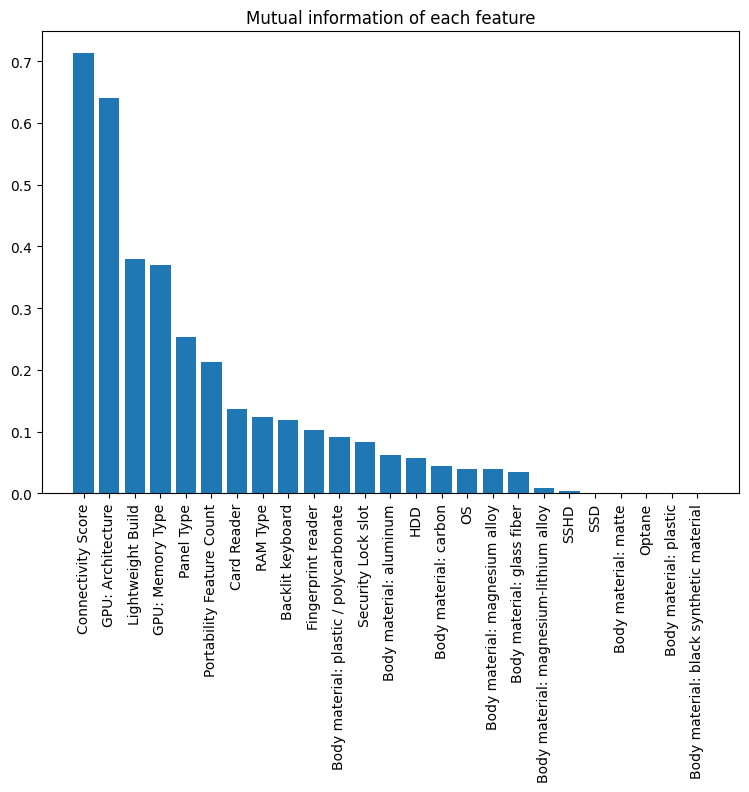

In [13]:
# mutual info
fs = SelectKBest(score_func=mutual_info_regression, k=10)
fs.fit(normalized_X_train[categorical_features],y_train)
d=sorted([(a,b) for a,b in zip(categorical_features,fs.scores_)],key=lambda x:x[1],reverse=True)
d={a:b for a,b in d}
plt.figure(figsize=(9,6))
plt.bar(d.keys(),d.values())
plt.xticks(rotation=90)
plt.title("Mutual information of each feature")
plt.show()

C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 9 23 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


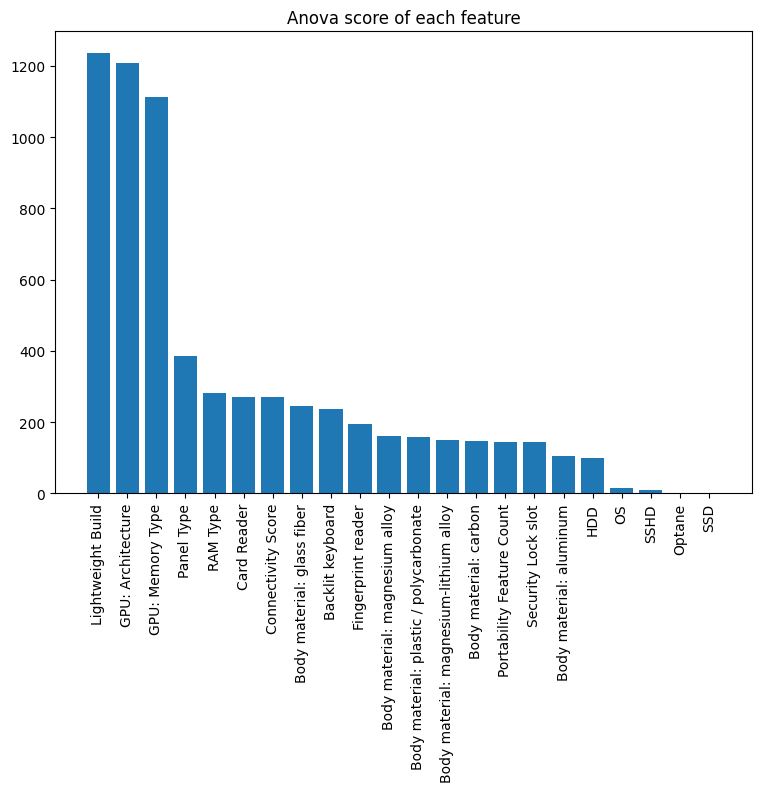

In [14]:
#anova
fs2 = SelectKBest(score_func=f_classif, k=10)
fs2.fit(normalized_X_train[categorical_features],y_train)
fs2.get_feature_names_out()
e=sorted([(a,b) for a,b in zip(categorical_features,fs2.scores_) if not np.isnan(b)],key=lambda x:x[1],reverse=True)
e={a:b for a,b in e}
plt.figure(figsize=(9,6))
plt.bar(e.keys(),e.values())
plt.xticks(rotation=90) 
plt.title("Anova score of each feature")
plt.show()

Using pearson, spearman correlation to find the most relevant in numerical features

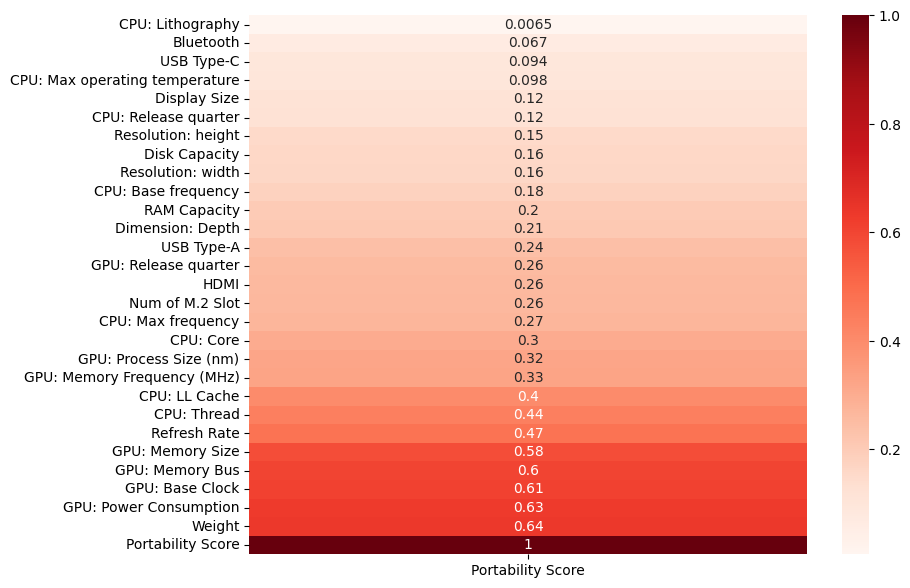

In [15]:
# using pearson score
train_set=X_train.join(y_train)
corr_df=train_set[numerical_features+[target]]
target_correlation = corr_df.corr()[[target]]
plt.figure(figsize=(9,7))
sns.heatmap(target_correlation.abs().sort_values(by=target), annot=True, cmap=plt.cm.Reds)
plt.show()

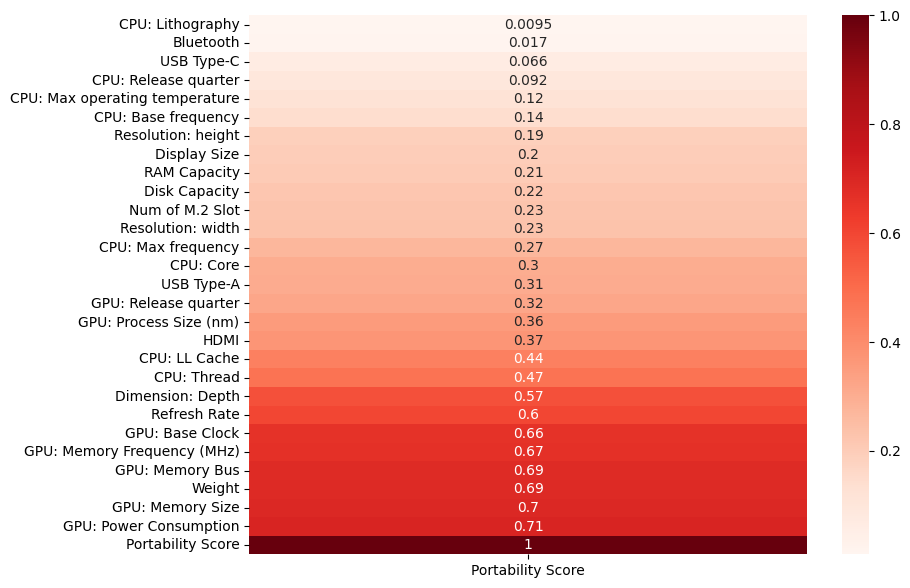

In [16]:
# using spearman score
train_set=X_train.join(y_train)
corr_df=train_set[numerical_features+[target]]
target_correlation = corr_df.corr(method = 'spearman')[[target]]
plt.figure(figsize=(9,7))
sns.heatmap(target_correlation.abs().sort_values(by=target), annot=True, cmap=plt.cm.Reds)
plt.show()

Using Random Forest to choose important features in 2 groups

In [34]:
# Choose candidate features in 2 groups
candidate_num_features = target_correlation[target].abs().sort_values(ascending=False).index[1:6].tolist()
d=sorted([(a,b) for a,b in zip(categorical_features,fs.scores_)],key=lambda x:x[1],reverse=True)
candidate_cat_features = list(feat[0] for feat in d[:5])
candidate_featues = candidate_cat_features + candidate_num_features
print(candidate_featues)

['Connectivity Score', 'GPU: Architecture', 'Lightweight Build', 'GPU: Memory Type', 'Panel Type', 'GPU: Power Consumption', 'GPU: Memory Size', 'Weight', 'GPU: Memory Bus', 'GPU: Memory Frequency (MHz)']


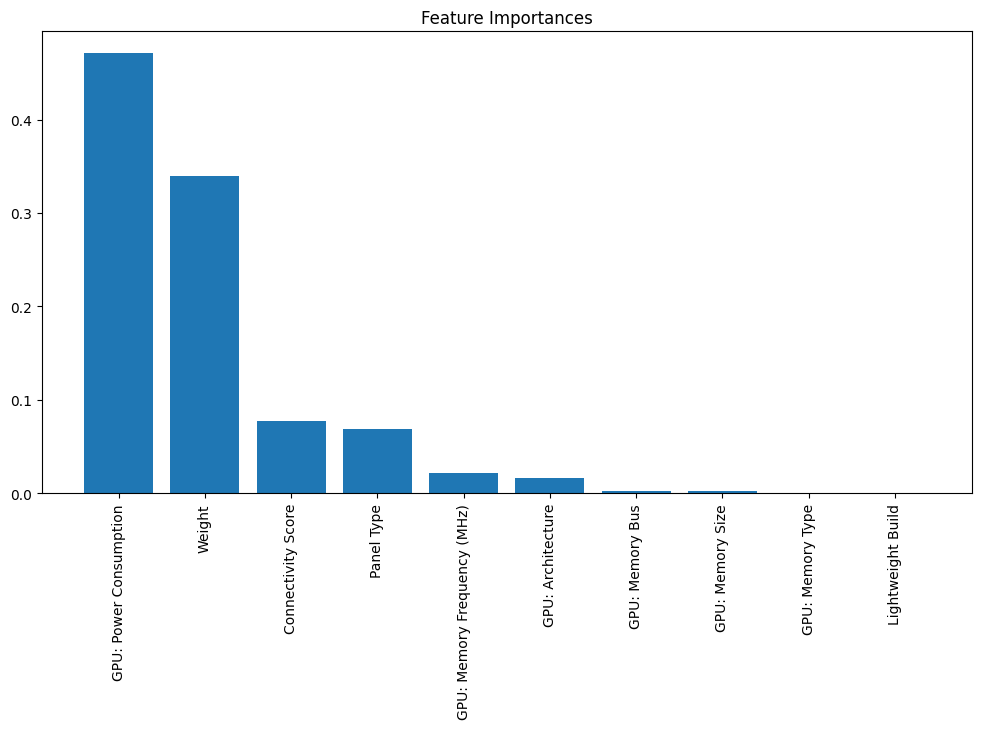

In [35]:
candidate_X = X_train[candidate_featues]
model = RandomForestRegressor()
model.fit(candidate_X, y_train)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), candidate_X.columns[indices], rotation='vertical')
plt.show()

In [36]:
choosen_features = ["GPU: Power Consumption", "Weight", "Panel Type", "Card Reader","GPU: Memory Frequency (MHz)","GPU: Architecture"]

Outlier Detection 

In [37]:
for feat in choosen_features:
    Q1 = np.percentile(X_train[feat], 25)
    Q3 = np.percentile(X_train[feat], 75)
    IQR = Q3 - Q1 
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = X_train[(X_train[feat] < lower_bound) | (X_train[feat]> upper_bound)]
    print("Number of outlier in feature "+ feat+": "+"{}".format(len(outliers)))

Number of outlier in feature GPU: Power Consumption: 0
Number of outlier in feature Weight: 421
Number of outlier in feature Panel Type: 15305
Number of outlier in feature Card Reader: 0
Number of outlier in feature GPU: Memory Frequency (MHz): 7926
Number of outlier in feature GPU: Architecture: 0


C:\Users\Acer\AppData\Local\Temp\ipykernel_24648\397844822.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, ax=ax, color='blue', shade=True, alpha=0.3)
C:\Users\Acer\AppData\Local\Temp\ipykernel_24648\397844822.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, ax=ax, color='blue', shade=True, alpha=0.3)
C:\Users\Acer\AppData\Local\Temp\ipykernel_24648\397844822.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, ax=ax, color='blue', shade=True, alpha=0.3)
C:\Users\Acer\AppData\Local\Temp\ipykernel_24648\397844822.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill

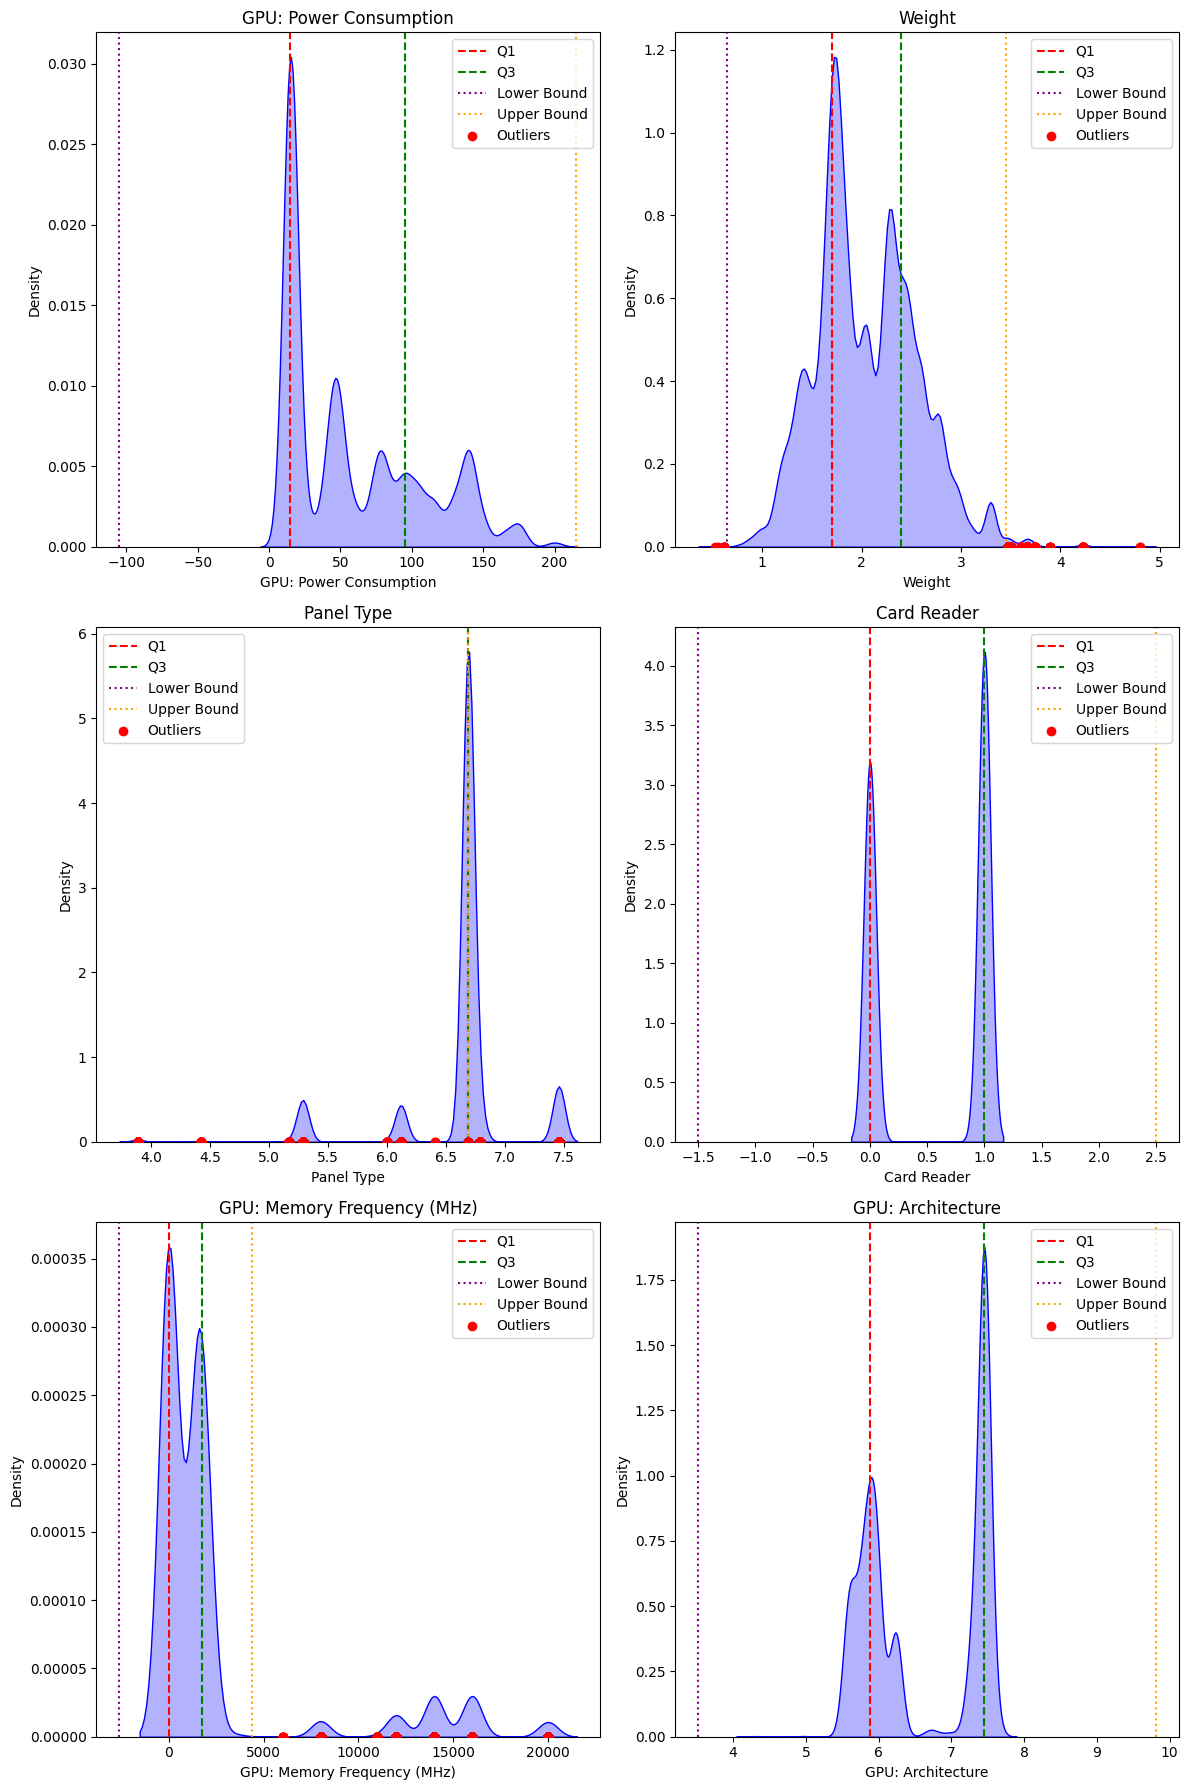

In [38]:
# Drawing the distribution of all features and the Q-percentile technique for outlier detection before deciding technique used to remove outliers
def detect_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return Q1, Q3, IQR, lower_bound, upper_bound, outliers
def plot_distribution(data, ax, title):
    Q1, Q3, IQR, lower_bound, upper_bound, outliers = detect_outliers(data) 
    ax.axvline(Q1, color="red", linestyle="--", label="Q1")
    ax.axvline(Q3, color="green", linestyle="--", label="Q3")
    ax.axvline(lower_bound, color="purple", linestyle=":", label="Lower Bound")
    ax.axvline(upper_bound, color="orange", linestyle=":", label="Upper Bound")
    sns.kdeplot(data, ax=ax, color='blue', shade=True, alpha=0.3)
    ax.scatter(outliers, [0] * len(outliers), color="red", label="Outliers", zorder=5)
    ax.set_title(title)
    ax.legend()
n_features = len(choosen_features)
n_cols = 2  
n_rows = (n_features + n_cols - 1) // n_cols  
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 6 * n_rows))
axes = axes.flatten()  

for i in range(n_features):
    plot_distribution(X_train[choosen_features[i]], axes[i], choosen_features[i])

plt.tight_layout()
plt.show()

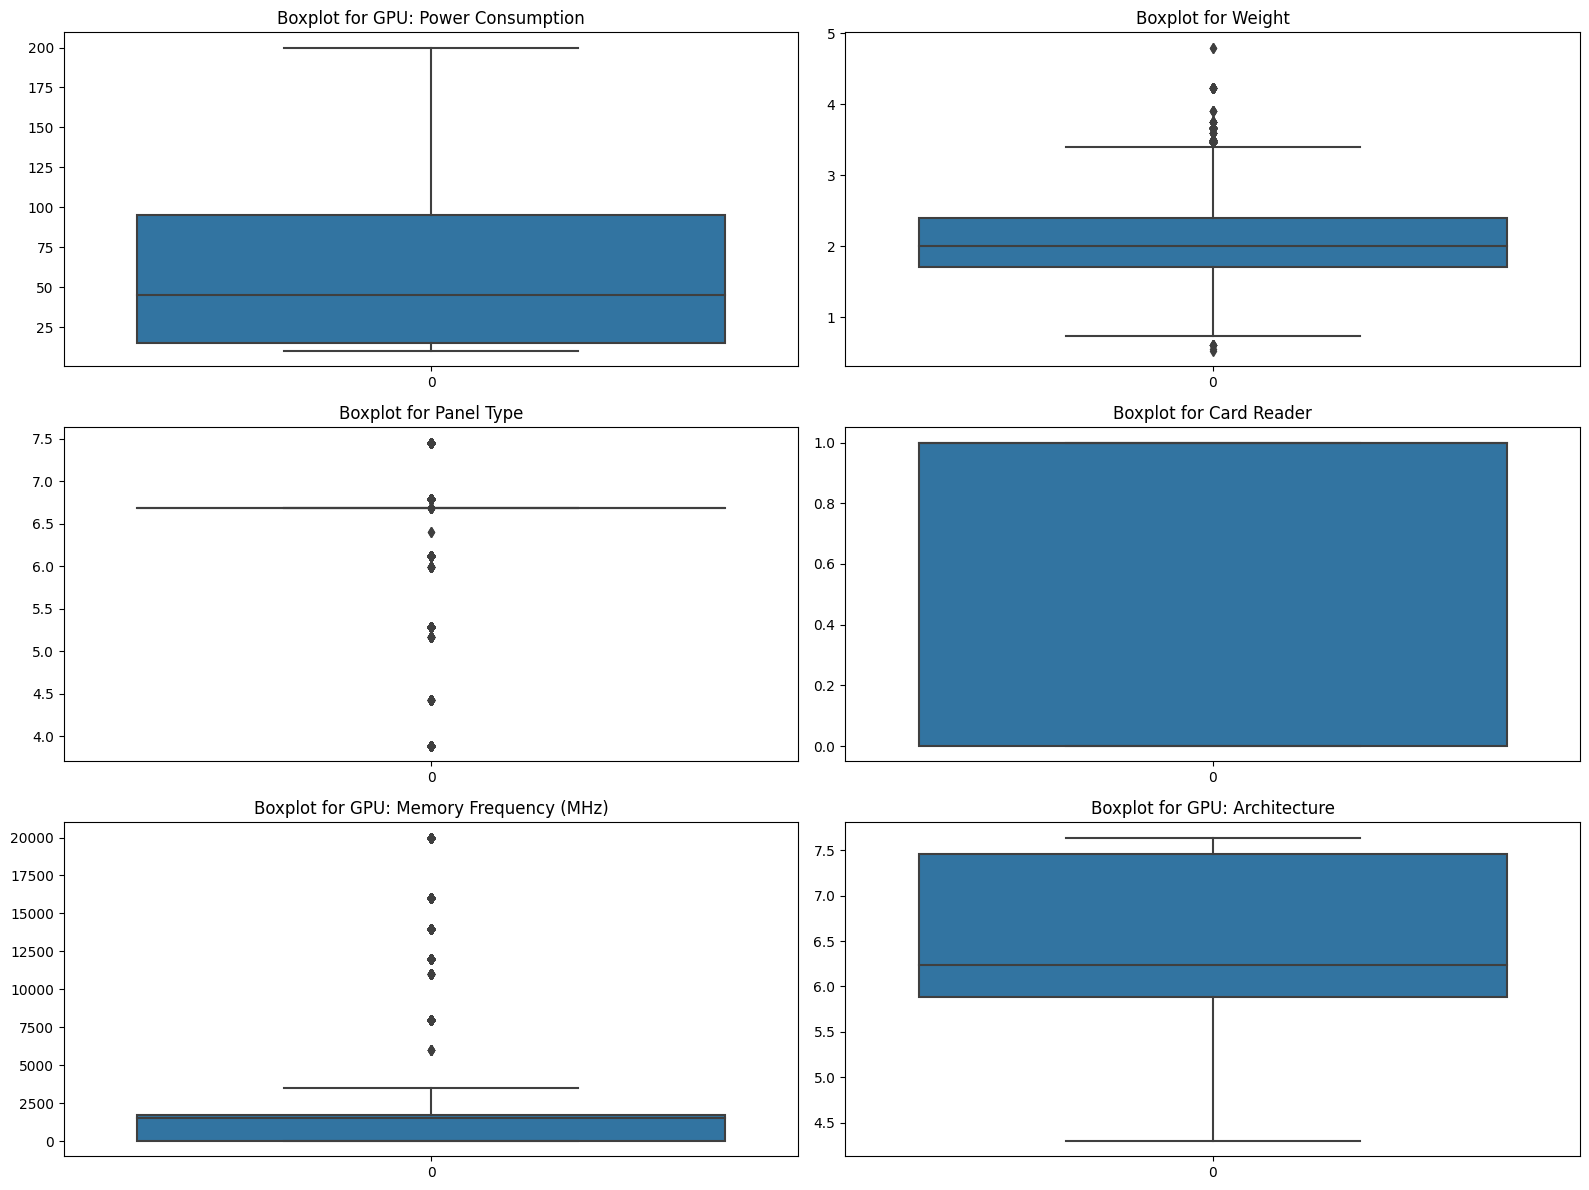

In [39]:
plt.figure(figsize=(16,12))
for i,var in enumerate(choosen_features):
  plt.subplot(3,2,i+1)
  sns.boxplot(X_train[var])
  plt.title(f'Boxplot for {var}')
plt.tight_layout()
plt.show()
  

In [40]:
#Removal of outliers in weight by using
Q1, Q3, IQR, lower_bound, upper_bound, outliers = detect_outliers(X_train["Weight"])
print("Original X_train shape:", X_train.shape[0])
reduced_X_train = X_train[(X_train["Weight"] >= lower_bound) & (X_train["Weight"] <= upper_bound)]
reduced_y_train = y_train[reduced_X_train.index]
print("Reduced X_train shape:", reduced_X_train.shape[0])
print("Reduced y_train shape:", reduced_y_train.shape[0])


Original X_train shape: 62389
Reduced X_train shape: 61968
Reduced y_train shape: 61968


Plot the relationship between the features and the target

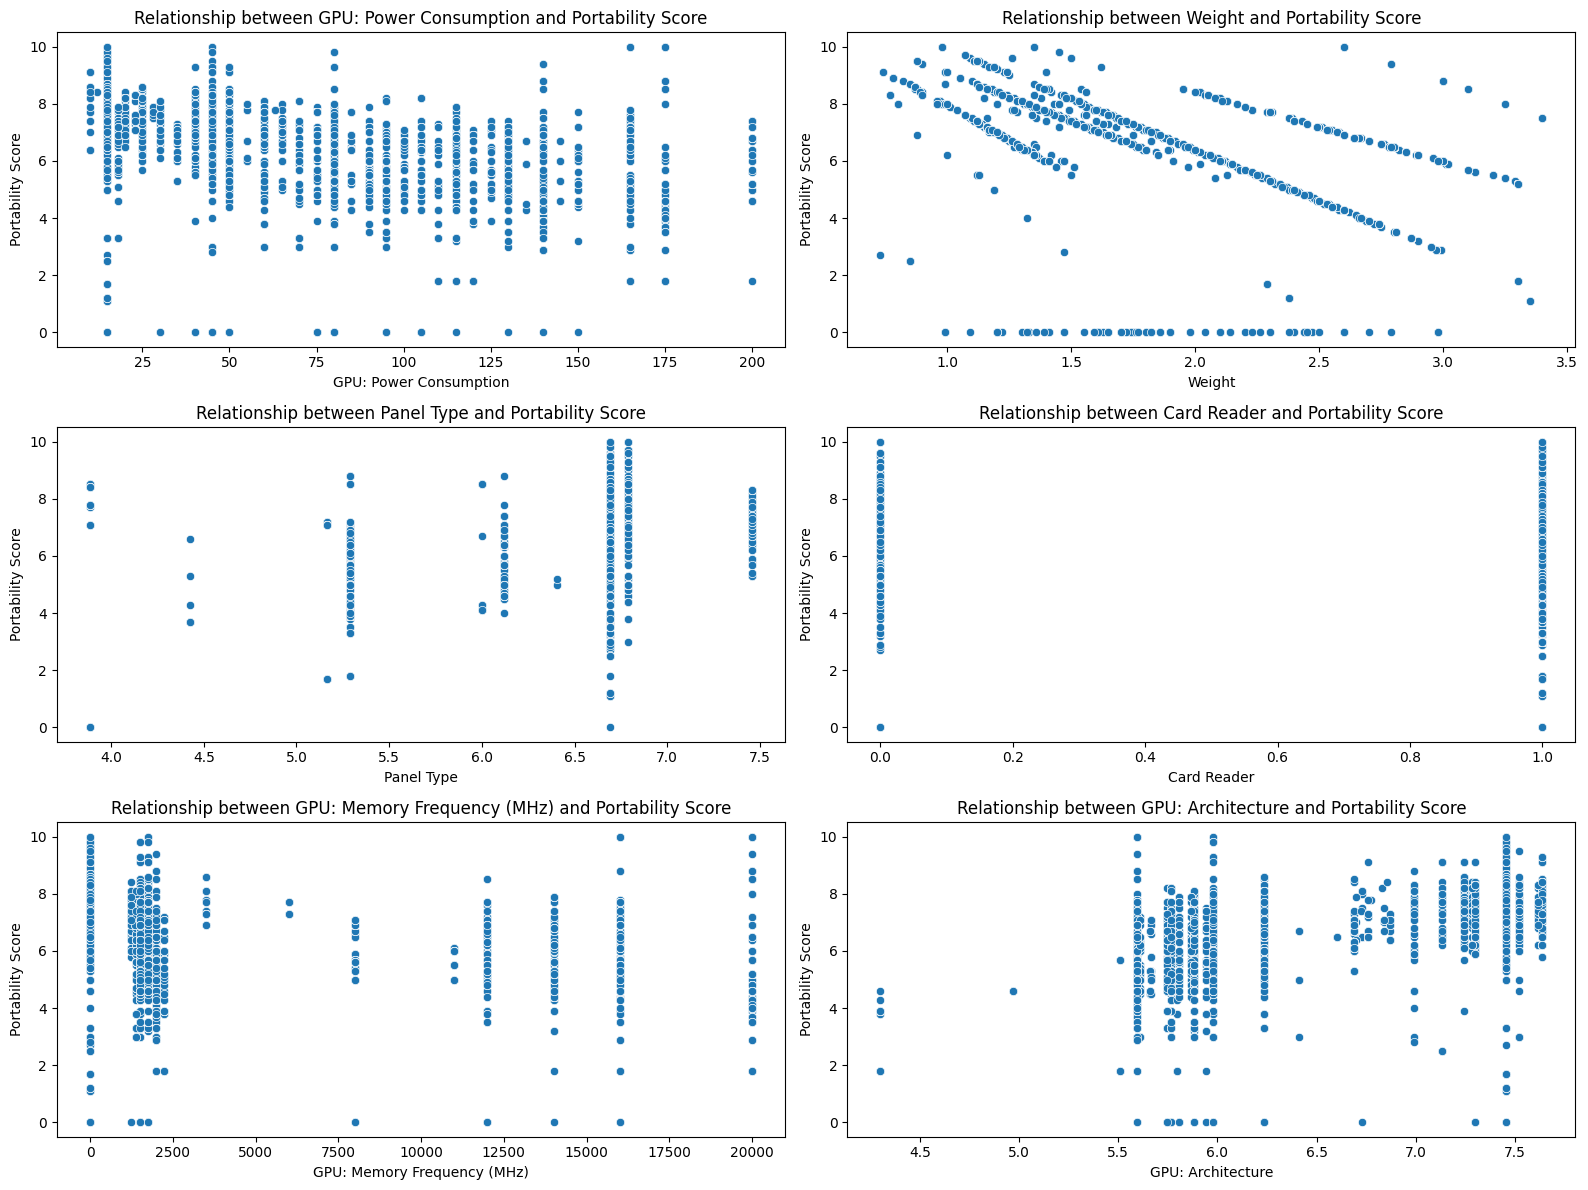

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
for i,var in enumerate(choosen_features):
  plt.subplot(3,2,i+1)
  sns.scatterplot(x=reduced_X_train[var], y=reduced_y_train)
  plt.title(f'Relationship between {var} and Portability Score')
plt.tight_layout()
plt.show()

Fine-tuning hyperparameters

In [42]:
def plot(title, xlabel, X, Y, ylabel = "mse"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    plt.scatter(X,Y)

In [ ]:
scaler = StandardScaler()
normalized_X_train = scaler.fit_transform(X_train)
normalized_X_test = scaler.transform(X_test)

Gradient Boosting Regression

100%|██████████| 3/3 [04:57<00:00, 99.24s/it] 


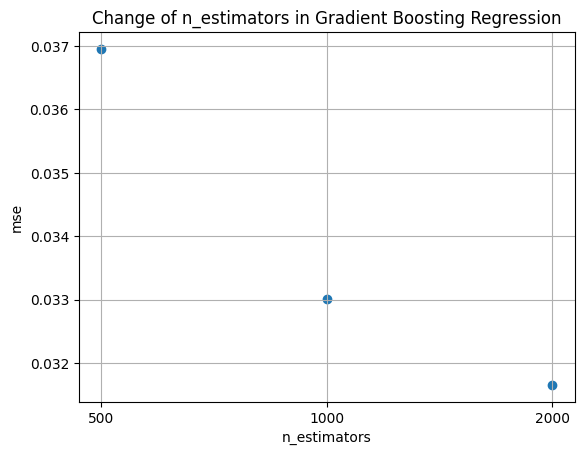

In [ ]:
title = "Change of n_estimators in Gradient Boosting Regression"
xlabel = "n_estimators"
X = []
Y = []
scaler = StandardScaler()
normalized_y_train = scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
for n_estimators in tqdm([5000]):
    model = GradientBoostingRegressor(n_estimators=n_estimators)
    model.fit(normalized_X_train, normalized_y_train)
    normalized_y_pred = model.predict(normalized_X_test)
    y_pred =  scaler.transform(normalized_y_pred.reshape(-1, 1))
    mse = mean_squared_error(y_test, y_pred)
    X.append(str(n_estimators))
    Y.append(mse)
plot(title, xlabel, X, Y)
plt.show()

KNN Regression

100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


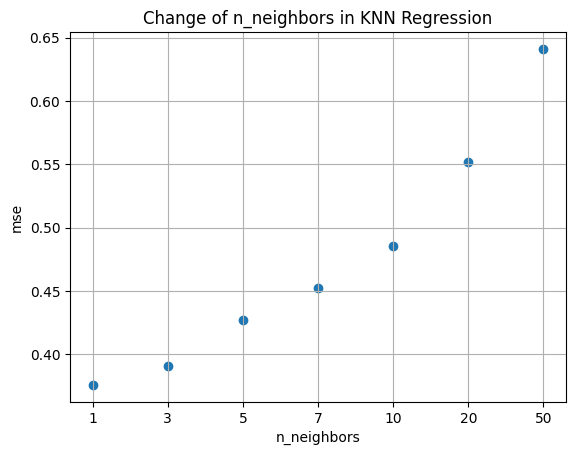

In [ ]:
title = "Change of n_neighbors in KNN Regression"
xlabel = "n_neighbors"
X = []
Y = []
for n_neighbors in tqdm([1, 3, 5, 7, 10,20, 50]):
    model = KNeighborsRegressor(n_neighbors=n_neighbors, metric = 'minkowski')
    model.fit(normalized_X_train, normalized_y_train)
    normalized_y_pred = model.predict(normalized_X_test)
    y_pred =  scaler.transform(normalized_y_pred.reshape(-1, 1))
    mse = mean_squared_error(y_test, y_pred)
    X.append(str(n_neighbors))
    Y.append(mse)
plot(title, xlabel, X, Y)
plt.show()

Random Forest Regression 

100%|██████████| 3/3 [03:35<00:00, 71.72s/it]


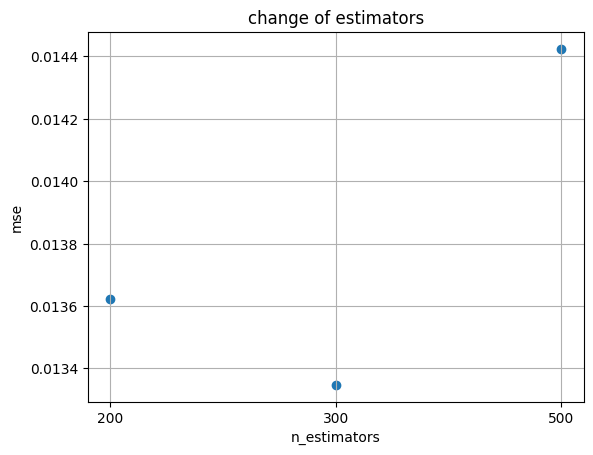

In [ ]:
title = "change of estimators"
xlabel = "n_estimators"
X = []
Y = []
criterion = 'squared_error'
for n_estimators in tqdm([200, 300, 500]):
    model = RandomForestRegressor(criterion=criterion, n_estimators=n_estimators)
    model.fit(normalized_X_train, normalized_y_train)
    normalized_y_pred = model.predict(normalized_X_test)
    y_pred =  scaler.transform(normalized_y_pred.reshape(-1, 1))
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    X.append(str(n_estimators))
    Y.append(mse)
plot(title, xlabel, X, Y)
plt.show()

Results of each model in this dataset after fine-tuned hyper-parameters

In [ ]:
models = {
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting' : GradientBoostingRegressor()
}

def train(X_train, y_train, X_test, y_test):
    for name, model in models.items():
        print(f"Training and evaluating {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"{name} - Mean Squared Error: {mse}, R-squared: {r2}")